# Compare model performance with three different transformation types
> A cross-validated approach to verify the impact of a feature on a model


- toc: true 
- badges: true
- comments: true
- categories: [sound, hugging face, fastai]
- image: images/K-fold.png

In this notebook, I walk you through three different transformation types for audio (wav) files for a ten-class classification problem.  In this example, I am using a vision-based algorithm; hence it is easy to visualize the importance of features from a visual perspective and their impact on model performance. 

The three different transformation types are:
- Linear Spectrograms
- Log Spectrograms
- Mel Spectrograms

You can learn more about these three transformations in [Scott Duda's article](https://scottmduda.medium.com/urban-environmental-audio-classification-using-mel-spectrograms-706ee6f8dcc1) and [Ketan Doshi's writing](https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505), reasoning why Mel Spectrograms perform better in general for visual transformations of audio files.


This notebook will test these three transforms on this Urban Sounds 8K dataset and how they perform with a pre-trained vision-based model (Resnet-34) leveraging Fastaiv2.  This notebook converts these sounds to a spectrogram then uses FastAI2 code base to classify these sounds. Code and approach in this notebook 

There are ten folders in this dataset as part of the data source and we will approach this as a ten-fold cross-validation for a proper comparative metric with other research papers. 


![](images/K-fold.png)

## About the UrbanSounds8K dataset

Urban Sounds is a dataset of 8732 labeled sounds of less than 4 seconds each from 10 classes. Dataset for [UrbanSounds8K](https://urbansounddataset.weebly.com/urbansound8k.html) contains these 10 classes:

1.  air_conditioner
2.  car_horn
3.  children_playing
4.  dog_bark
5.  drilling
6.  engine_idling
7.  gun_shot
8.  jackhammer
9.  siren
10. street_music


[Research with this dataset as of 2019](https://www.researchgate.net/publication/335862311_Evaluation_of_Classical_Machine_Learning_Techniques_towards_Urban_Sound_Recognition_on_Embedded_Systems) and optimized ML approaches as of late 2019 had classification accuracy at 74% with a k-nearest neighbours (KNN) algorithm. A deep learning neural network trained from scratch obtained accuracy at 76% accuracy.


![Accuracy metrics](https://www.researchgate.net/profile/Bruno-Silva-172/publication/335862311/figure/fig2/AS:804132151652353@1568731453277/Achieved-accuracy-of-the-classifiers-with-their-default-and-optimized-configuration.png "research")

*(accuracy metrics for research article)*


## Setup Section

### The installs and incldues

You could use a non-GPU machine type for some file conversions as they are computationally expensive.  For this, I am using an ml.p3.2xlarge.  For the deep learning model, you could run it just as well on an ml.g4.2xlarge at a reduced cost. 

In [ ]:
#collapse-hide
#One time installs  - On AWS useconda_pytorch_p38 environment and add using ml.p3.2xlarge for this notebook
# !pip install librosa
# !pip install fastbook

In [1]:
#collapse-hide
#all the one time imports for this nb
import pandas as pd

from fastai.vision.all import *
from fastai.data.all import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from pathlib import Path
import os
import random
import IPython
from tqdm import tqdm

from collections import OrderedDict

### Download files from source then uncompress

These subsequent steps ensure adequate space to get the initial files and following transformations.  I set aside 100GB. 

In [3]:
#collapse-show
# One time download files to local S3 folder
# !wget https://goo.gl/8hY5ER  #download
# !tar xf 8hY5ER #unpack tar file

### File classification information

Note that this file provides classification information once unpacked. 

In [4]:
#collapse-show
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')  #classification information across folds as provided from Urbansounds
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Data exploration

##### Class distribution across the sound types

Text(0.5, 1.0, 'Class distribution in the dataset')

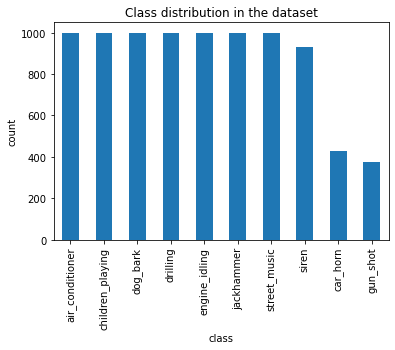

In [5]:
#collapse-hide
df.groupby('class').classID.count().sort_values(ascending=False).plot.bar()
plt.ylabel('count')
plt.title('Class distribution in the dataset')

These classification files show that overall classes are represented, with a gunshot and car horns being slightly underrepresented relative to all others. 

Each of the folds has a relatively similar number of wav files.


Text(0.5, 1.0, 'Files in each fold')

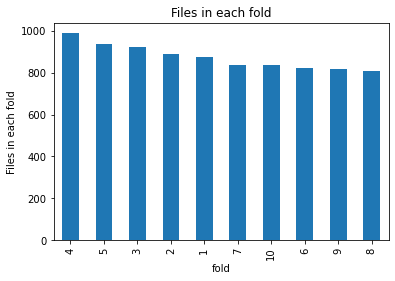

In [6]:
#collapse-hide
df.groupby(['fold']).classID.count().sort_values(ascending=False).plot.bar()
plt.ylabel('Files in each fold')
plt.title('Files in each fold')

##### Inspect the files - audio and single tranform of a audio file

Listen to a sample wav file - it happens to be a dog barking, an urban sound.

In [7]:
#collapse-hide

audio_file= 'UrbanSound8K/audio/fold5/100032-3-0-0.wav'   #dog bark in fold 5

IPython.display.Audio(audio_file)

##  Single File Transformation

##### Linear Spectrogram

With the librosa module, these are the steps to convert a single wave file to a simple spectrogram.  We stay with the dog barking audio representation as a spectrogram.

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


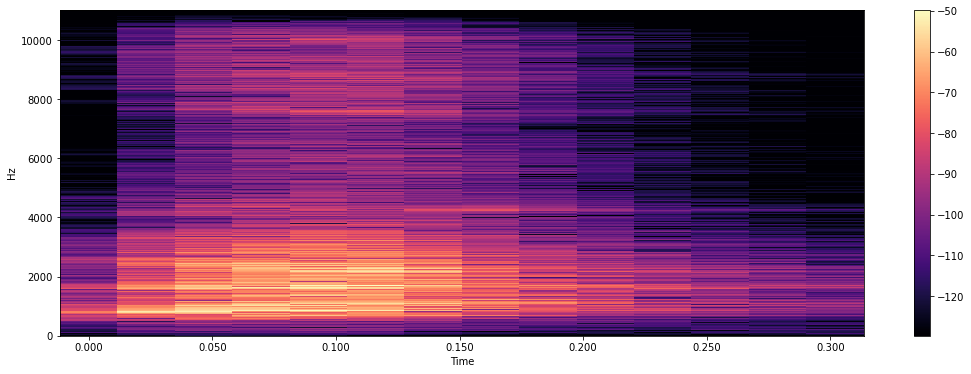

In [8]:
#collapse-hide

samples, sample_rate = librosa.load(audio_file)
Ydb = librosa.amplitude_to_db(librosa.stft(samples), ref=sample_rate)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='linear')
plt.colorbar()

##### Log Spectrogram


Again, a spectrogram can have a log representation for the dog barking in log space. 

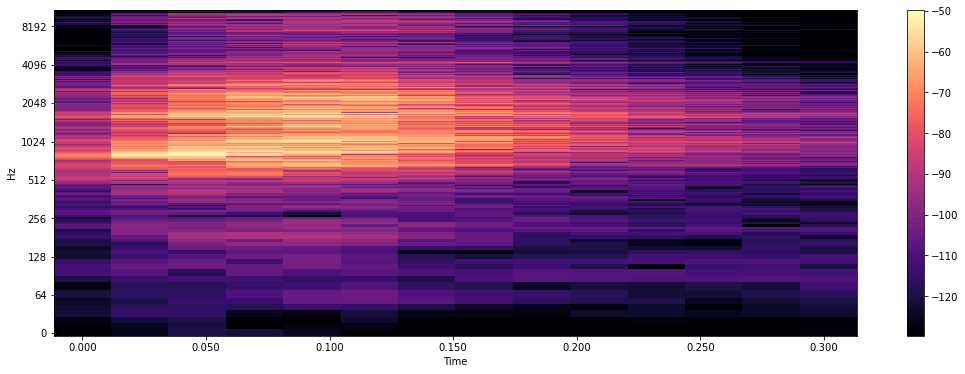

In [9]:
#collapse-hide

plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

##### Mel Spectrogram

And finally, this code transforms the same audio file into a mel-spectrogram.  Note the added level of intensity and representation in a mel-spectrogram.

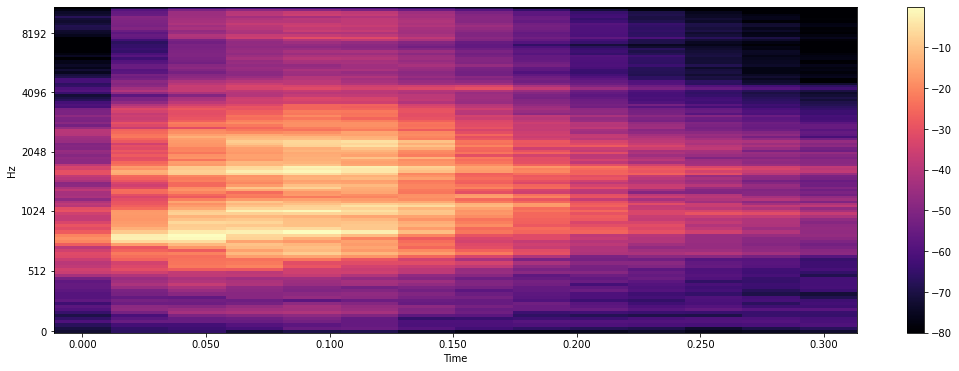

In [10]:
#collapse-hide

S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
Sdb = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Sdb, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar()

## 8K Files into Three Transformations

The below code creates folders for the transformed image files from the 8K wav files.  Note the minor change from the single-file approach for images - we can drop the axes as machines don't need these - a picture without axes works best. 


This step takes a significant amount of time; it needs to be done once.


In [11]:
#collapse-hide

audio_path = Path('UrbanSound8K/audio/')  # un zipped source audio files are in this location as wav files
tranform_store_path = 'UrbanSoundTransforms/'  #destination folder for each transformed image state

In [12]:
#collapse-hide

#make initial folders once
#os.mkdir(tranform_store_path)
# os.mkdir(tranform_store_path +'linear_spectrogram')
# os.mkdir(tranform_store_path +'log_spectrogram')
# os.mkdir(tranform_store_path +'mel_spectrogram')

In [13]:
#collapse-hide
# for fold in np.arange (1,11):
#     print(f'Processing fold {fold}')
#     try:
#         os.mkdir(tranform_store_path+'linear_spectrogram/'+ str(fold))
#         os.mkdir(tranform_store_path+'log_spectrogram/'+ str(fold))
#         os.mkdir(tranform_store_path+'mel_spectrogram/'+str(fold))
#     except:
#         pass #Folder exists
#     for audio_file in tqdm(list(Path(audio_path/f'fold{fold}').glob('*.wav'))):
#         samples, sample_rate = librosa.load(audio_file)  #create onces with librosa
        
#         #plot for linear spectrogram - without axis, tight 
        
#         fig = plt.figure(figsize=[0.72,0.72])
#         ax = fig.add_subplot(111)
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)
#         ax.set_frame_on(False)
#         Ydb = librosa.amplitude_to_db(librosa.stft(samples), ref=sample_rate)
#         LS = librosa.display.specshow(Ydb, sr=sample_rate, x_axis='time', y_axis='linear')
#         filename  = tranform_store_path + 'linear_spectrogram/'+str(fold) +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
#         plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
#         plt.close('all')
        
#         #plot for log  spectrogram - without axis, tight 
#         fig = plt.figure(figsize=[0.72,0.72])
#         ax = fig.add_subplot(111)
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)
#         ax.set_frame_on(False)
#         LogS = librosa.display.specshow(Ydb, sr=sample_rate,x_axis='time', y_axis='log')
#         filename  = tranform_store_path + 'log_spectrogram/'+str(fold) +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
#         plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
#         plt.close('all')
        
#         #plot for mel spectrogram - without axis, tight
        
#         fig = plt.figure(figsize=[0.72,0.72])
#         ax = fig.add_subplot(111)
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)
#         ax.set_frame_on(False)
#         melS = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
#         librosa.display.specshow(librosa.power_to_db(melS, ref=np.max))
#         filename  = tranform_store_path + 'mel_spectrogram/'+str(fold) +'/'+ str(audio_file).split('/')[-1:][0].replace('.wav','.png')
#         plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
#         plt.close('all')
        

##### Validate all files are transformed in destination folds

Validate that all 8K files converted into the three types of transformations

In [14]:
#collapse-show
transforms = ['linear_spectrogram/','log_spectrogram/','mel_spectrogram/']
for transform in transforms:
    count = 0
    for fold in np.arange (1,11):
        count += len(list(Path(tranform_store_path+transform+str(fold)).glob('*.png')))
    print ('%s file count is %s'%(transform[:-1],count))
    assert (len(df)==count)

linear_spectrogram file count is 8732
log_spectrogram file count is 8732
mel_spectrogram file count is 8732


In [15]:
#collapse-show
classes = OrderedDict(sorted(df.set_index('classID').to_dict()['class'].items()))
classes

OrderedDict([(0, 'air_conditioner'),
             (1, 'car_horn'),
             (2, 'children_playing'),
             (3, 'dog_bark'),
             (4, 'drilling'),
             (5, 'engine_idling'),
             (6, 'gun_shot'),
             (7, 'jackhammer'),
             (8, 'siren'),
             (9, 'street_music')])

##### Visual inspection for each sound category

In this bit of code, we look at each of the transformed depictions across the ten-classes

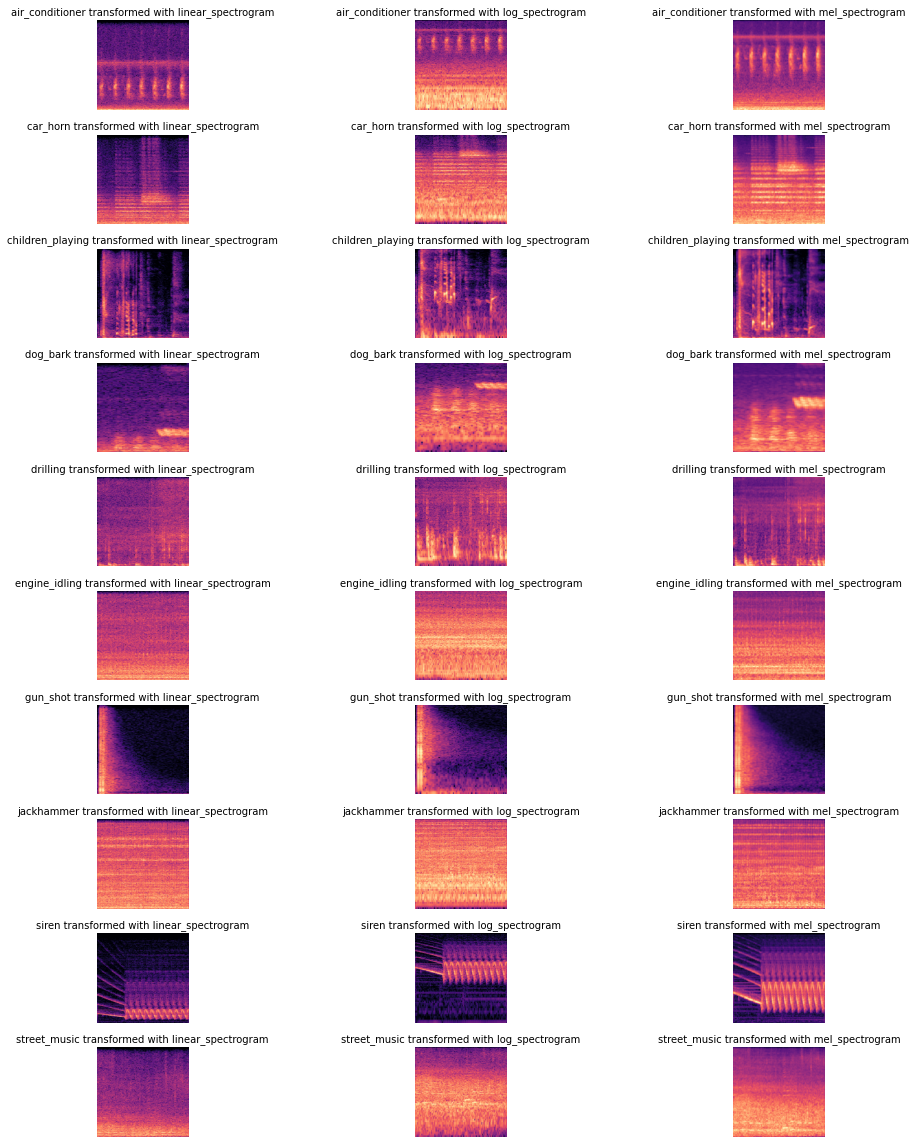

In [16]:
#collapse-show
fig, ax = plt.subplots(10,3, figsize=(16,16))
for k,v in classes.items():
    sample = df[df['class']==v].sample(1)
    sample_fold = sample['fold'].values[0]
    sample_file = sample['slice_file_name'].values[0].replace('wav','png')
    t_counter=0
    for transform in transforms:
        img = plt.imread(tranform_store_path+transform+str(sample_fold)+'/'+sample_file)
        ax[k][t_counter].imshow(img, aspect='equal')
        ax[k][t_counter].set_title(v+' transformed with '+ transform[:-1])
        ax[k][t_counter].title.set_size(10)
        ax[k][t_counter].set_axis_off()
        
        t_counter+=1
fig.tight_layout()
plt.show()

## Fast AI Model Build

From the reference file where our sources were in wav format, we will change them to png for each file name and create a dictionary objection with class for a filename. 

In [17]:
#collapse-show
df['fname'] = df[['slice_file_name','fold']].apply (lambda x: str(x['slice_file_name'][:-4])+'.png'.strip(),axis=1 )

This labelling function uses the dictionary object and returns the class.  We drop the parts of the path and focus on the filename, which is unique across the 8K files. 

In [18]:
#collapse-show
my_dict = dict(zip(df.fname,df['class']))

In [19]:
#collapse-show
def label_func(f_name):
    f_name = str(f_name).split('/')[-1:][0]
    return my_dict[f_name]

In [20]:
#collapse-show
all_folds = list(np.arange(1,11))
all_folders = [str(i) for i in all_folds]
all_folders

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [21]:
#collapse-show
results = pd.DataFrame()

We create a list of the ten folds as strings for a downstream code in this bit of code.  A Resnet-34 model runs for three epochs for comparative analysis.  This code runs the k-fold type prediction with a single fold as a test across the three file transformation folders.  This code takes a significant amount of time and uses the GPU. 

In [22]:
#collapse-show
for transform in transforms:
    all_files = get_image_files(path=tranform_store_path+transform,recurse=True, folders =all_folders )
    
    for test_folder in all_folds:
        
        dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_y     = label_func,
                   
                   splitter  = FuncSplitter(lambda s: Path(s).parent.name==str(test_folder)),
                   
                  )
        dl = dblock.dataloaders(all_files)
        
        print ('Train has {0} images and test has {1} images. Test is on folder {2} of transform type {3}.' .format(len(dl.train_ds),len(dl.valid_ds),test_folder,transform[:-1]))
        learn = vision_learner(dl, resnet34, metrics=accuracy)
        learn.fine_tune(3)
        r = learn.validate()
        results.at[test_folder,transform[:-1]] = r[1]
        

Train has 7859 images and test has 873 images. Test is on folder 1 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.646356,1.303435,0.592211,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.734405,1.158944,0.670103,00:41
1,0.349336,1.062735,0.715922,00:41
2,0.120102,1.035805,0.735395,00:42


Train has 7844 images and test has 888 images. Test is on folder 2 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.618032,1.471006,0.550676,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.750616,1.395346,0.643018,00:42
1,0.339488,1.213989,0.685811,00:42
2,0.122644,1.223365,0.698198,00:42


Train has 7807 images and test has 925 images. Test is on folder 3 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.609933,1.212611,0.585946,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.713603,1.071660,0.663784,00:42
1,0.354776,1.287965,0.656216,00:42
2,0.110639,1.320493,0.678919,00:42


Train has 7742 images and test has 990 images. Test is on folder 4 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.643499,1.288041,0.597980,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.720948,1.036399,0.688889,00:42
1,0.335754,0.818471,0.760606,00:42
2,0.113218,0.871289,0.763636,00:42


Train has 7796 images and test has 936 images. Test is on folder 5 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.648136,1.279705,0.588675,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.761581,0.919619,0.705128,00:42
1,0.345561,0.714063,0.792735,00:42
2,0.121579,0.691167,0.791667,00:42


Train has 7909 images and test has 823 images. Test is on folder 6 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.640491,1.461258,0.562576,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.722605,1.607899,0.646416,00:43
1,0.325290,1.414237,0.693803,00:43
2,0.110730,1.377959,0.712029,00:43


Train has 7894 images and test has 838 images. Test is on folder 7 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.594230,1.479910,0.517900,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.705556,0.951557,0.717184,00:43
1,0.306930,1.075511,0.704057,00:43
2,0.109320,0.981054,0.717184,00:43


Train has 7926 images and test has 806 images. Test is on folder 8 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.618264,1.568802,0.529777,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.736232,1.685889,0.589330,00:43
1,0.322088,1.566928,0.645161,00:43
2,0.113493,1.512315,0.676179,00:43


Train has 7916 images and test has 816 images. Test is on folder 9 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.662708,1.191227,0.609069,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.738244,0.937917,0.752451,00:43
1,0.342161,0.828607,0.797794,00:43
2,0.110757,0.838220,0.789216,00:43


Train has 7895 images and test has 837 images. Test is on folder 10 of transform type linear_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.639923,1.204564,0.646356,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.715795,0.857385,0.756272,00:43
1,0.351518,0.753865,0.792115,00:43
2,0.122999,0.661824,0.832736,00:43


Train has 7859 images and test has 873 images. Test is on folder 1 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.650926,1.132629,0.621993,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.664109,0.927699,0.726231,00:42
1,0.279372,0.983903,0.741123,00:43
2,0.087220,0.917430,0.746850,00:43


Train has 7844 images and test has 888 images. Test is on folder 2 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.580881,1.473966,0.564189,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.660235,1.674381,0.662162,00:43
1,0.261079,1.347339,0.721847,00:43
2,0.086787,1.303460,0.730856,00:43


Train has 7807 images and test has 925 images. Test is on folder 3 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.554419,1.265764,0.601081,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.645222,1.155872,0.647568,00:42
1,0.276456,1.479933,0.660541,00:42
2,0.085445,1.405435,0.684324,00:42


Train has 7742 images and test has 990 images. Test is on folder 4 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.574416,1.410470,0.570707,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.651727,0.948870,0.710101,00:42
1,0.285824,0.963551,0.746465,00:42
2,0.092143,0.833476,0.763636,00:42


Train has 7796 images and test has 936 images. Test is on folder 5 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.584739,1.040504,0.685897,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.659326,0.788796,0.753205,00:42
1,0.294902,0.901573,0.777778,00:42
2,0.096744,0.684919,0.795940,00:43


Train has 7909 images and test has 823 images. Test is on folder 6 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.568830,1.537969,0.565006,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.629603,1.329358,0.693803,00:43
1,0.270114,1.239127,0.761847,00:43
2,0.093767,1.230025,0.765492,00:43


Train has 7894 images and test has 838 images. Test is on folder 7 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.551806,1.253360,0.609785,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.634409,1.354680,0.698091,00:43
1,0.257725,1.049563,0.757757,00:43
2,0.086514,1.006423,0.762530,00:43


Train has 7926 images and test has 806 images. Test is on folder 8 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.594089,1.724049,0.547146,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.639673,1.433562,0.689826,00:43
1,0.279755,1.512132,0.697270,00:43
2,0.083887,1.416594,0.719603,00:43


Train has 7916 images and test has 816 images. Test is on folder 9 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.617574,1.245562,0.634804,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.661609,0.909678,0.781863,00:43
1,0.275348,0.984878,0.787990,00:43
2,0.088735,1.004140,0.794118,00:43


Train has 7895 images and test has 837 images. Test is on folder 10 of transform type log_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.547163,1.147652,0.640382,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.634231,0.794007,0.801673,00:43
1,0.255871,0.729826,0.813620,00:43
2,0.083886,0.691131,0.835125,00:43


Train has 7859 images and test has 873 images. Test is on folder 1 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.438649,0.855717,0.723940,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.538291,1.242817,0.709049,00:42
1,0.215221,1.033411,0.757159,00:43
2,0.067709,1.043618,0.750286,00:42


Train has 7844 images and test has 888 images. Test is on folder 2 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.419769,1.318493,0.602477,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.576866,1.232487,0.674550,00:43
1,0.199539,1.151864,0.721847,00:43
2,0.065879,1.218944,0.724099,00:42


Train has 7807 images and test has 925 images. Test is on folder 3 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.399783,1.344811,0.575135,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.530457,1.246315,0.652973,00:42
1,0.206290,1.100291,0.717838,00:42
2,0.066169,1.039851,0.722162,00:42


Train has 7742 images and test has 990 images. Test is on folder 4 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.398213,1.226020,0.614141,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.530371,0.979655,0.722222,00:42
1,0.212438,0.769903,0.780808,00:42
2,0.068044,0.774077,0.772727,00:43


Train has 7796 images and test has 936 images. Test is on folder 5 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.424381,0.938384,0.684829,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.540425,0.622973,0.818376,00:42
1,0.230166,0.432847,0.876068,00:42
2,0.075813,0.379239,0.887821,00:42


Train has 7909 images and test has 823 images. Test is on folder 6 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.394642,1.405592,0.620899,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.513183,1.323630,0.707169,00:43
1,0.226495,1.160470,0.746051,00:43
2,0.076572,1.182628,0.755772,00:43


Train has 7894 images and test has 838 images. Test is on folder 7 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.361491,1.206686,0.630072,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.514640,1.079973,0.744630,00:43
1,0.215227,0.871684,0.768496,00:43
2,0.073965,0.989660,0.779236,00:43


Train has 7926 images and test has 806 images. Test is on folder 8 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.353415,1.392421,0.629032,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.528919,1.156052,0.700993,00:43
1,0.209949,1.182361,0.745658,00:43
2,0.069247,1.138816,0.771712,00:43


Train has 7916 images and test has 816 images. Test is on folder 9 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.420336,1.109759,0.703431,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.546160,1.094824,0.769608,00:43
1,0.217296,1.037101,0.813725,00:43
2,0.067287,0.964782,0.833333,00:43


Train has 7895 images and test has 837 images. Test is on folder 10 of transform type mel_spectrogram.


epoch,train_loss,valid_loss,accuracy,time
0,1.366528,1.066314,0.714456,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.544914,0.848490,0.790920,00:43
1,0.219007,0.895404,0.808841,00:43
2,0.079304,0.896217,0.824373,00:43


## Prediction Results

In [30]:
#collapse-show
results

,linear_spectrogram,log_spectrogram,mel_spectrogram
1,0.735395,0.746850,0.750286
2,0.698198,0.730856,0.724099
3,0.678919,0.684324,0.722162
4,0.763636,0.763636,0.772727
5,0.791667,0.795940,0.887821
6,0.712029,0.765492,0.755772
7,0.717184,0.762530,0.779236
8,0.676179,0.719603,0.771712
9,0.789216,0.794118,0.833333
10,0.832736,0.835125,0.824373


In [31]:
#collapse-show
results.describe()

,linear_spectrogram,log_spectrogram,mel_spectrogram
count,10.000000,10.000000,10.000000
mean,0.739516,0.759847,0.782152
std,0.052835,0.042857,0.052126
min,0.676179,0.684324,0.722162
25%,0.701656,0.734854,0.751658
50%,0.726289,0.763083,0.772220
75%,0.782821,0.786961,0.813089
max,0.832736,0.835125,0.887821


<AxesSubplot:>

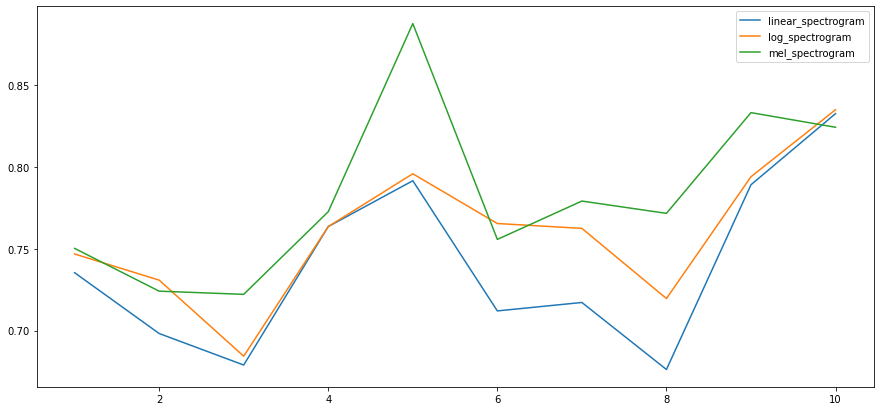

In [32]:
#collapse-show
results.plot.line(figsize=(15,7))

Across the board, mel-spectrogram seems to outperform the other two transformations with a minor exception at the 10th fold.  

We can inspect the losses in this category through the fast ai library, spot any classification issue or potentially these sounds having multiple classes, and change them.  But since this is a provided dataset, we will not change any of the categories. 

In [36]:
#collapse-show

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dl.valid_ds)==len(losses)==len(idxs)

True

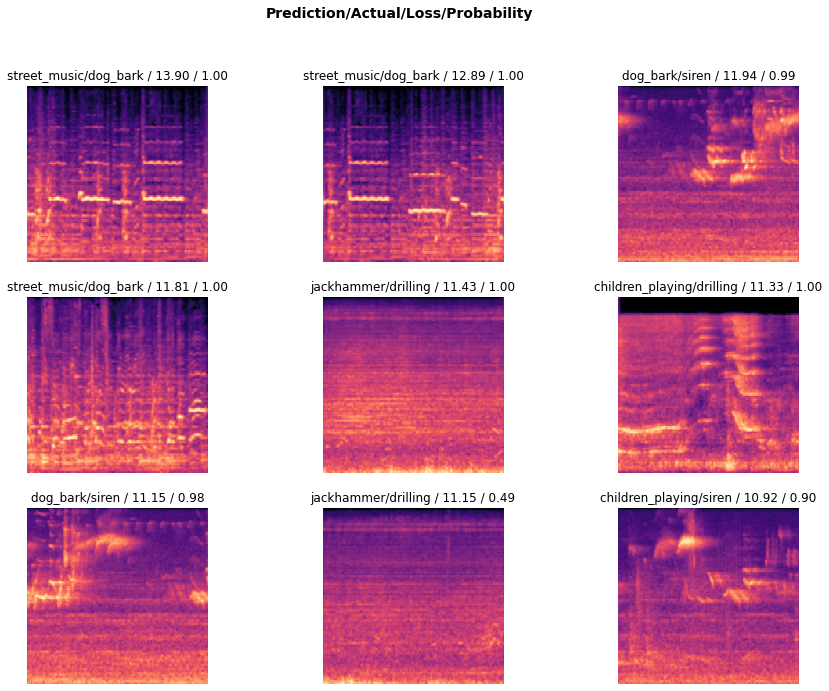

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

In [40]:
doc(interp.plot_top_losses)

Interpretation.plot_top_losses(k, largest=True, **kwargs)
Show `k` largest(/smallest) preds and losses. `k` may be int, list, or `range` of desired results.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


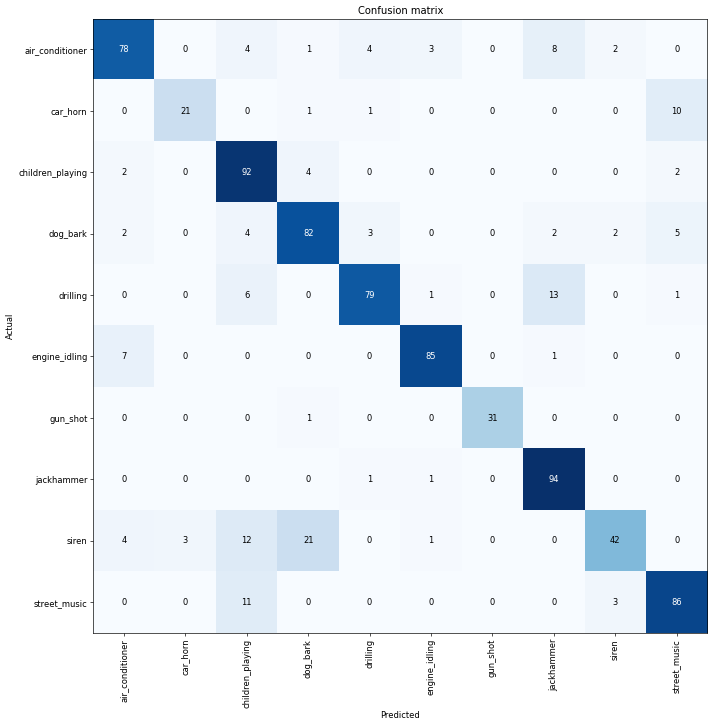

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Summary


- Mel spectrograms tend to outperform linear and log spectrograms for human audio sounds.
- We didn't explore further tuning the model or trying other models, but a 90% range accuracy for the mean is attainable for this dataset. 
- The 95% results in an earlier notebook are attributable to randomness from how the train-test split worked out on this model. 

You can try out the mel-spectrogram trained with a random split from this [hugging face link](https://huggingface.co/spaces/gputrain/UrbanSounds8K) or find out [how I made this](https://www.gputrain.com/sound/hugging%20face/fastai/2022/05/26/Deploying-my-first-HuggingFace-space.html). 